<a href="https://colab.research.google.com/github/Ankesh-21/Deep-Learning/blob/main/DeepFakeVideo_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip /content/drive/MyDrive/test.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/test/SRM/fake/id0_id16_0004/id0_id16_0004_face_SRM_000025.jpg  
  inflating: content/test/SRM/fake/id0_id16_0004/id0_id16_0004_face_SRM_000113.jpg  
  inflating: content/test/SRM/fake/id0_id16_0004/id0_id16_0004_face_SRM_000318.jpg  
  inflating: content/test/SRM/fake/id0_id16_0004/id0_id16_0004_face_SRM_000004.jpg  
  inflating: content/test/SRM/fake/id0_id16_0004/id0_id16_0004_face_SRM_000031.jpg  
  inflating: content/test/SRM/fake/id0_id16_0004/id0_id16_0004_face_SRM_000278.jpg  
  inflating: content/test/SRM/fake/id0_id16_0004/id0_id16_0004_face_SRM_000254.jpg  
  inflating: content/test/SRM/fake/id0_id16_0004/id0_id16_0004_face_SRM_000243.jpg  
  inflating: content/test/SRM/fake/id0_id16_0004/id0_id16_0004_face_SRM_000072.jpg  
  inflating: content/test/SRM/fake/id0_id16_0004/id0_id16_0004_face_SRM_000177.jpg  
  inflating: content/test/SRM/fake/id0_id16_0004/id0_id16_0004_face_SRM_000116.jpg  
  inflating: c

In [2]:
import os
import zipfile
from PIL import Image
import numpy as np

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [4]:
def preprocess(path1, path2, label):
    ELA_images = []
    SRM_images = []
    labels = []

    prefix = 'real' if label == 0 else 'fake'
    ela_root = os.path.join(path1, prefix)
    srm_root = os.path.join(path2, prefix)

    folders = sorted(os.listdir(ela_root))
    cnt = 0
    for folder in folders:
        ela_folder_path = os.path.join(ela_root, folder)
        srm_folder_path = os.path.join(srm_root, folder)

        if not os.path.exists(srm_folder_path):
            continue

        ela_files = sorted(os.listdir(ela_folder_path))
        srm_files = sorted(os.listdir(srm_folder_path))

        for ela_file, srm_file in zip(ela_files, srm_files):
            ela_path = os.path.join(ela_folder_path, ela_file)
            srm_path = os.path.join(srm_folder_path, srm_file)

            try:
                ela_img = Image.open(ela_path).convert('RGB').resize((256, 256))
                srm_img = Image.open(srm_path).convert('RGB').resize((256, 256))

                ELA_images.append(np.array(ela_img))
                SRM_images.append(np.array(srm_img))
                labels.append(label)

            except Exception as e:
                print(f"Skipping image pair ({ela_file}, {srm_file}): {e}")
        cnt += 1
        if cnt == 2:
          break
    return ELA_images, SRM_images, labels

In [5]:
# Paths to your dataset folders
path1 = '/content/content/test/ELA'
path2 = '/content/content/test/SRM'

# Load and preprocess both classes
ela_real, srm_real, labels_real = preprocess(path1, path2, label=0)
ela_fake, srm_fake, labels_fake = preprocess(path1, path2, label=1)

# Merge data without using np.concatenate (faster and lower memory)
ELA_total = np.array(ela_real + ela_fake, dtype=np.float32) / 255.0
SRM_total = np.array(srm_real + srm_fake, dtype=np.float32) / 255.0
labels_total = np.array(labels_real + labels_fake)

print(f"Loaded {len(labels_total)} samples.")
print(f"ELA shape: {ELA_total.shape}, dtype: {ELA_total.dtype}")
print(f"SRM shape: {SRM_total.shape}, dtype: {SRM_total.dtype}")

Loaded 1432 samples.
ELA shape: (1432, 256, 256, 3), dtype: float32
SRM shape: (1432, 256, 256, 3), dtype: float32


In [6]:
ELA_train, ELA_test, SRM_train, SRM_test, y_train, y_test = train_test_split(
    ELA_total, SRM_total, labels_total, test_size=0.2, random_state=42, stratify=labels_total)
# Free up memory by deleting original large arrays and calling garbage collection
del ELA_total, SRM_total, labels_total
del ela_real, ela_fake, srm_real, srm_fake, labels_real, labels_fake

import gc
gc.collect()


0

In [7]:
def build_model(input_shape=(256, 256, 3)):
    """Your model architecture"""
    # ELA Branch
    input_ela = layers.Input(shape=input_shape, name='ELA_Input')
    x_ela = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_ela)
    x_ela = layers.BatchNormalization()(x_ela)
    x_ela = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_ela)
    x_ela = layers.BatchNormalization()(x_ela)
    x_ela = layers.MaxPooling2D((2, 2))(x_ela)
    x_ela = layers.Dropout(0.2)(x_ela)

    # SRM Branch
    input_srm = layers.Input(shape=input_shape, name='SRM_Input')
    x_srm = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_srm)
    x_srm = layers.BatchNormalization()(x_srm)
    x_srm = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_srm)
    x_srm = layers.BatchNormalization()(x_srm)
    x_srm = layers.MaxPooling2D((2, 2))(x_srm)
    x_srm = layers.Dropout(0.2)(x_srm)

    # Concatenate the outputs of both branches
    combined = layers.Concatenate()([x_ela, x_srm])
    combined = layers.Flatten()(combined)

    # Fully connected layers
    fc = layers.Dense(256, activation='relu')(combined)
    fc = layers.BatchNormalization()(fc)
    fc = layers.Dropout(0.5)(fc)
    output = layers.Dense(1, activation='sigmoid')(fc)

    # Create the model
    model = models.Model(inputs=[input_ela, input_srm], outputs=output)

    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [8]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              min_delta = 0,
                              patience = 7,
                              verbose = 1,
                              restore_best_weights=True,
                              mode = 'max')

In [9]:
model = build_model()

In [14]:
print("Training samples:", len(y_train))
history = model.fit(
    [ELA_train, SRM_train],
    y_train,
    epochs=20,
    batch_size=16,
    validation_data = ([ELA_test, SRM_test], y_test),
    callbacks = [early_stopping]
)

Training samples: 1145
Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 37s 396ms/step - accuracy: 0.9926 - loss: 0.0498 - val_accuracy: 0.9721 - val_loss: 0.0895
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.9936 - loss: 0.0327 - val_accuracy: 0.9686 - val_loss: 0.0849
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.9988 - loss: 0.0238 - val_accuracy: 0.9721 - val_loss: 0.0794
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 1.0000 - loss: 0.0172 - val_accuracy: 0.9652 - val_loss: 0.0927
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9993 - loss: 0.0196 - val_accuracy: 0.9547 - val_loss: 0.1028
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.9959 - loss: 0.0181 - val_accuracy: 0.9791 - val_loss: 0.0733
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.9984 - loss: 0.0134 - val_accuracy: 0.9861 - val_loss: 0.0597
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 1.0000 - 

In [15]:
y_pred_prob = model.predict([ELA_test, SRM_test])
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


Accuracy: 0.9860627177700348


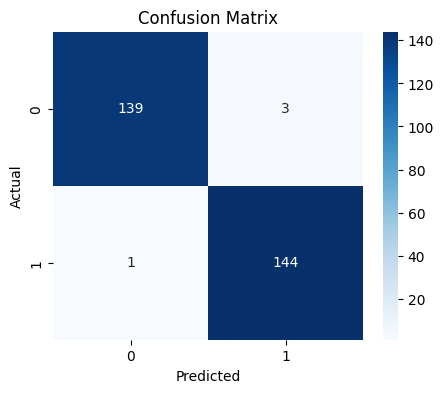

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


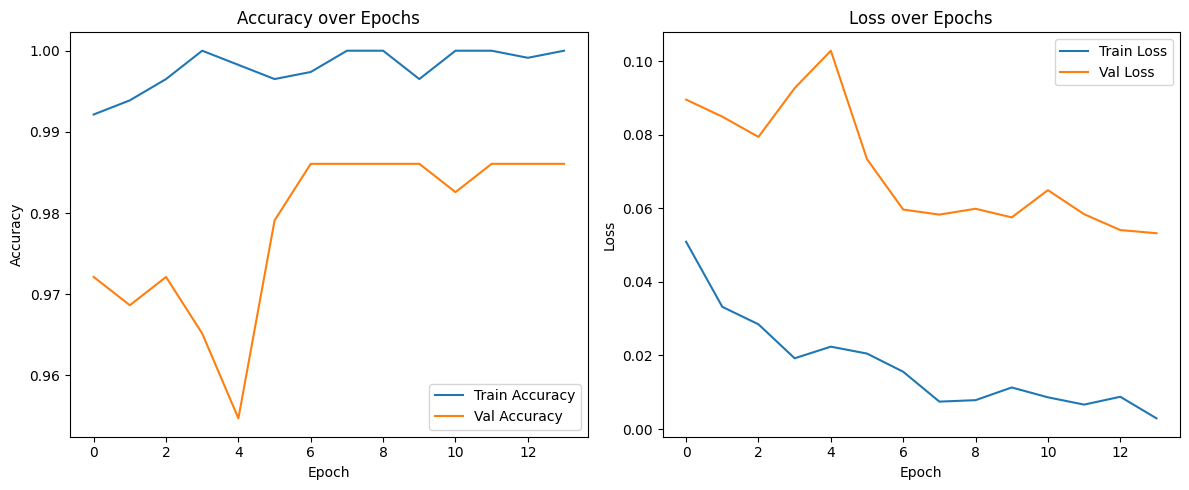

In [17]:
# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()